## HS-Palmer omics traits analysis：

This notebook explains the process for obtaining and pre-processing omics mean genotype data of HS Rats used for downstream association studies.

In [342]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim, StatsBase
using Random, Distributions
using BenchmarkTools
using Plots

In [343]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/HS-Palmer"

In [3]:
local_path = "../../BulkLMM.jl/src";

In [4]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));
include("../../BigRiver_util_code/src/kinship_utils.jl");
include("../../BigRiver_util_code/src/run_gemma_utils.jl");

### Load omics traits and convert to array:

In [178]:
@time omics_pheno_df = CSV.read("/home/zyu20/shareddata/HSNIH-Palmer/HSNIH-Rat-PL-RSeq-0818_nomissing.csv", DataFrame);

  1.195464 seconds (1.11 M allocations: 84.568 MiB, 2.10% gc time)


After removing missings the traits data have 32624 traits on 80 samples:

In [344]:
size(omics_pheno_df)

(80, 32624)

In [192]:
omics_pheno_df[1:10, 1:10]

Row,id,ENSRNOG00000000001,ENSRNOG00000000007,ENSRNOG00000000008,ENSRNOG00000000009,ENSRNOG00000000010,ENSRNOG00000000012,ENSRNOG00000000017,ENSRNOG00000000021,ENSRNOG00000000024
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,00077E67B5,3.6379,11.9384,1.5656,0.142,8.1366,4.2163,2.9092,7.6822,9.5078
2,00077E76FE,3.7742,11.9253,1.5245,-0.068,8.2848,4.663,2.8339,7.8128,9.5016
3,00077E8336,3.554,12.2001,1.3987,-0.0679,8.1853,4.5741,2.5846,7.705,9.4759
4,00077EA7E6,3.3301,11.9553,1.6367,-0.0218,8.066,4.4902,2.5845,7.6575,9.3513
5,00078A0224,3.5547,12.0272,1.5649,-0.0217,8.3169,4.5341,2.6773,7.8402,9.3225
6,00078A02CB,3.8215,12.0395,1.3515,-0.0679,8.3208,4.5923,2.6765,7.6363,9.4791
7,00078A0A43,3.6407,12.0575,1.4871,-0.0678,8.2847,4.6763,2.7223,7.7997,9.4048
8,00078A18A7,3.6343,12.0777,1.4854,-0.0679,8.0468,4.7543,2.7599,7.8119,9.3522
9,00078A193E,3.6807,12.1188,1.5244,-0.068,8.1551,4.8433,2.7173,7.9472,9.2675


Column names are the names of the omics:

In [7]:
names(omics_pheno_df)[1:6]

6-element Vector{String}:
 "id"
 "ENSRNOG00000000001"
 "ENSRNOG00000000007"
 "ENSRNOG00000000008"
 "ENSRNOG00000000009"
 "ENSRNOG00000000010"

Row names are the ID's of the samples. Obtaining sample id's for the samples of the omics traits...

In [8]:
sample_ids = omics_pheno_df[:, 1];

Get the numeric array of the traits data...

In [9]:
omics_pheno = omics_pheno_df[:, 2:end] |> Matrix{Float64};
omics_pheno[1:6, :]

6×32623 Matrix{Float64}:
 3.6379  11.9384  1.5656   0.142   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.7742  11.9253  1.5245  -0.068      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.554   12.2001  1.3987  -0.0679     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.3301  11.9553  1.6367  -0.0218     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.5547  12.0272  1.5649  -0.0217     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.8215  12.0395  1.3515  -0.0679  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Notice that there are some traits with all 0.0 values. Remove missings or columns of all 0's...

In [229]:
no_value_traits = vec(sum(abs.(omics_pheno), dims = 1) .== 0.0);

In [230]:
omics_pheno_processed = omics_pheno[:, map(x -> x .== 0.0, no_value_traits)];

In [231]:
size(omics_pheno_processed)

(80, 18416)

The processed traits data after removing potentially missing values have 18416 traits.

### Load omics genotype data and convert to array:

The genotyped data has been through the pre-processing of filtering out observations for samples that are not phenotyped, and removing missing values...the processes are detailed in the notebook `process_omics_geno.ipynb`.

In [198]:
@time omics_geno_df = CSV.read("/home/zyu20/shareddata/HSNIH-Palmer/HSNIH-Palmer_true_omics_geno_nomissing.csv", DataFrame);

  0.134497 seconds (1.36 M allocations: 117.995 MiB)


In [199]:
omics_geno_df

Row,Chr,Locus,cM,Mb,00077E67B5,00077E76FE,00077E8336,00077EA7E6,00078A002C,00078A0041,00078A0058,00078A0085,00078A00AC,00078A00BF,00078A01A6,00078A01C0,00078A01D8,00078A01DB,00078A01FE,00078A02CB,00078A02DF,00078A07A2,00078A09B1,00078A021A,00078A022D,00078A087B,00078A096C,00078A0127,00078A0138,00078A0139,00078A0166,00078A0215,00078A0224,00078A0246,00078A0255,00078A0A43,00078A0AEA,00078A1A2B,00078A1A16,00078A1B05,00078A1F34,00078A16D3,00078A16DF,00078A17F7,00078A18A7,00078A18CF,00078A18F7,00078A19A7,00078A19B5,00078A19C0,00078A19D6,00078A22DF,00078A22EB,00078A179C,00078A181B,00078A186C,00078A192C,00078A193E,00078A194B,00078A261F,00078A1707,00078A1731,00078A1732,00078A1772,00078A1807,00078A1816,00078A1837,00078A1863,00078A1875,00078A1937,00078A1942,00078A1979,00078A2315,00078A2463,00078A2496,00078A2595,00078A2667,000789FF6E,000789FF7D,000789FF94,000789FFD3,000789FFF0,000789FFF8,000789FFF9
,Int64,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,chr1:55365,0.055365,0.055365,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
2,1,chr1:666374,0.666374,0.666374,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,1,chr1:666382,0.666382,0.666382,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1,chr1:666394,0.666394,0.666394,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
5,1,chr1:669529,0.669529,0.669529,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
6,1,chr1:669562,0.669562,0.669562,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0
7,1,chr1:671466,0.671466,0.671466,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0

In [14]:
@time omics_geno = omics_geno_df[:, 5:end] |> Array{Float64, 2} |> x -> permutedims(x) |> x -> x./2.0;

  0.357760 seconds (491.40 k allocations: 354.237 MiB, 17.01% gc time, 42.23% compilation time)


In [15]:
@time omics_marker_names = omics_geno_df.Locus |> Array{String, 1};
omics_marker_names[1:6]

  0.085377 seconds (268.46 k allocations: 12.260 MiB, 95.88% compilation time)


6-element Vector{String}:
 "chr1:55365"
 "chr1:666374"
 "chr1:666382"
 "chr1:666394"
 "chr1:669529"
 "chr1:669562"

#### Filter markers by MAF within the range of (0.05, 0.95)

In [200]:
@time maf_omics_geno = vec(mean(omics_geno; dims = 1));

  0.010541 seconds (10 allocations: 1.028 MiB)


In [201]:
to_keep = map(x -> (x < 0.95) & (x > 0.05), maf_omics_geno);

In [202]:
omics_marker_names

134681-element Vector{String}:
 "chr1:55365"
 "chr1:666374"
 "chr1:666382"
 "chr1:666394"
 "chr1:669529"
 "chr1:669562"
 "chr1:671466"
 "chr1:759319"
 "chr1:1134030"
 "chr1:1139210"
 "chr1:1143318"
 "chr1:1151014"
 "chr1:1151294"
 ⋮
 "chr20:55641278"
 "chr20:55644746"
 "chr20:55659520"
 "chr20:55716379"
 "chr20:55744179"
 "chr20:55773139"
 "chr20:55818290"
 "chr20:55944342"
 "chr20:55963803"
 "chr20:55991426"
 "chr20:55999627"
 "chr20:56115597"

In [176]:
omics_geno

80×134681 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.4985  …  1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.988      1.0  1.0  0.999   0.0065  1.0
 0.5  1.0  1.0  1.0  1.0  1.0  1.0  0.4955     1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  0.5  0.5  0.5  1.0  1.0  0.9895     1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0035     0.5  0.5  0.498   0.0455  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.9895  …  1.0  1.0  0.999   0.0065  1.0
 0.5  0.5  1.0  1.0  1.0  0.5  1.0  0.4955     1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.4985     1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.004      1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.9895     1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.4985  …  1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.4985     1.0  0.5  0.9975  0.007   1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0035     1.

After removing markers outside the MAF thresholds of 0.05, we get the genotyped data of the size:

In [203]:
omics_geno_processed = omics_geno[:, to_keep];
omics_marker_names_processed = omics_marker_names[to_keep];

In [206]:
size(omics_geno_processed)

(80, 117618)

with 80 samples on 117,618 markers.

In [204]:
(n, m) = size(omics_pheno_processed);
p = size(omics_geno_processed, 2);

In [205]:
n, m, p

(80, 18416, 117618)

### Load BulkLMM functions:

In [345]:
local_path = "/home/zyu20/git/BulkLMM.jl/src";

In [346]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));
include("../../BigRiver_util_code/src/kinship_utils.jl");
include("../../BigRiver_util_code/src/run_gemma_utils.jl");

In [357]:
@time omics_kinship = calcKinship(omics_geno_processed) |> x -> round.(x; digits = 12);

  0.142526 seconds (160.89 k allocations: 80.156 MiB, 39.84% gc time, 29.14% compilation time)


In [358]:
BLAS.get_num_threads()

16

In [359]:
BLAS.set_num_threads(16)

## BulkLMM:

In [389]:
grid_fine = collect(0.00:0.01:0.99);

In [361]:
grid_loose = collect(0.00:0.05:0.95);

In [388]:
t_null_grid20 = @elapsed bulkscan_null_grid_results20 = bulkscan_null_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_loose; reml = false);

In [390]:
t_null_grid100 = @elapsed bulkscan_null_grid_results100 = bulkscan_null_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_fine; reml = false);

In [391]:
t_null_grid20

13.915395807

In [397]:
test_y = reshape(omics_pheno_processed[:, 1], :, 1);

In [402]:
@time y_perms = scan(test_y, omics_geno_processed, omics_kinship; permutation_test = true, reml = false, nperms = 1000);

  1.453635 seconds (1.30 M allocations: 2.278 GiB, 34.39% gc time)


In [401]:
@time y_null = scan(test_y, omics_geno_processed, omics_kinship);

  0.964371 seconds (1.30 M allocations: 757.287 MiB, 30.53% gc time)


In [405]:
@time y_alt = scan(test_y, omics_geno_processed, omics_kinship; assumption = "alt");

 88.746328 seconds (193.59 M allocations: 85.851 GiB, 10.12% gc time)


In [403]:
hcat(y_null.lod, y_perms.lod) 

117618×2 Matrix{Float64}:
 0.340197    0.340197
 0.391565    0.391565
 0.288975    0.288975
 0.831917    0.831917
 0.325364    0.325364
 0.697638    0.697638
 0.550568    0.550568
 0.495616    0.495616
 0.299334    0.299334
 0.493727    0.493727
 0.437515    0.437515
 0.356815    0.356815
 0.229415    0.229415
 ⋮           
 0.0325104   0.0325104
 1.24786e-5  1.24786e-5
 4.45794e-6  4.45794e-6
 8.83031e-6  8.83031e-6
 2.23587e-6  2.23587e-6
 1.24786e-5  1.24786e-5
 0.00492947  0.00492947
 0.0847242   0.0847242
 0.146107    0.146107
 0.189778    0.189778
 0.155139    0.155139
 0.157019    0.157019

In [392]:
t_null_grid100

16.442067535

In [375]:
# grid_looser = [0.0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90];
grid_looser = [0.0, 0.95];

In [376]:
t_alt_grid2 = @elapsed bulkscan_alt_grid_results = bulkscan_alt_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_looser);

In [378]:
t_alt_grid2

122.816347266

In [371]:
bulkscan_alt_grid_results.L

117618×18416 Matrix{Float64}:
 0.340197    0.226361     0.00405807   …  0.405406    0.272795    0.120127
 0.391565    0.126534     0.0206568       1.00163     0.548643    0.11444
 0.288975    0.00103342   0.329974        0.0714303   0.0875217   0.122337
 0.831917    0.0817987    0.164024        0.00230466  0.154816    0.597666
 0.325364    0.0045107    0.549366        0.099927    0.0507671   0.338061
 0.697638    0.101465     0.217168     …  0.0133476   0.0975028   0.794292
 0.550568    0.0788087    0.0602317       0.00104111  0.00767557  0.506985
 0.495616    0.00894047   0.000135643     0.0140147   0.109979    0.266518
 0.299334    0.000206067  0.0674419       0.0796164   0.424535    0.0415577
 0.493727    0.00994813   0.192153        0.201892    0.348914    0.00836178
 0.437515    0.0836527    0.0184778    …  0.0100988   0.130018    0.14844
 0.356815    0.133987     0.0291973       0.0192121   0.244598    0.650927
 0.229415    0.128631     0.0221304       0.972031    0.63961     0.0

In [377]:
mean(bulkscan_alt_grid_results.h2_panel .== 0.0)

0.9973356539449693

In [373]:
bulkscan_null_grid_results100.L

117618×18416 Matrix{Float64}:
 0.340197    0.226361     0.00405807   …  0.405406    0.272795    0.120127
 0.391565    0.126534     0.0206568       1.00163     0.548643    0.11444
 0.288975    0.00103342   0.329974        0.0714303   0.0875217   0.122337
 0.831917    0.0817987    0.164024        0.00230466  0.154816    0.597666
 0.325364    0.0045107    0.549366        0.099927    0.0507671   0.338061
 0.697638    0.101465     0.217168     …  0.0133476   0.0975028   0.794292
 0.550568    0.0788087    0.0602317       0.00104111  0.00767557  0.506985
 0.495616    0.00894047   0.000135643     0.0140147   0.109979    0.266518
 0.299334    0.000206067  0.0674419       0.0796164   0.424535    0.0415577
 0.493727    0.00994813   0.192153        0.201892    0.348914    0.00836178
 0.437515    0.0836527    0.0184778    …  0.0100988   0.130018    0.14844
 0.356815    0.133987     0.0291973       0.0192121   0.244598    0.650927
 0.229415    0.128631     0.0221304       0.972031    0.63961     0.0

In [387]:
p

117618

In [380]:
mean(bulkscan_null_grid_results100.h2_null_list .== 0.0)

0.9964161598609904

In [383]:
findmax(abs.(bulkscan_alt_grid_results.L .- bulkscan_null_grid_results100.L))

(1.590547189451844, CartesianIndex(57047, 1070))

In [385]:
hcat(bulkscan_alt_grid_results.L[57047, 1070], bulkscan_null_grid_results100.L[57047, 1070], bulkscan_null_grid_results20.L[57047, 1070])

1×3 Matrix{Float64}:
 5.12451  3.53396  5.12451

In [386]:
hcat(bulkscan_alt_grid_results.h2_panel[57047, 1070], bulkscan_null_grid_results100.h2_null_list[1070], bulkscan_null_grid_results20.h2_null_list[1070])

1×3 Matrix{Float64}:
 0.0  0.99  0.0

## GEMMA:

In [186]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

"/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

In [187]:
# rand_samples = sample(1:m, 1000);

In [188]:
rand_samples = readdlm("output/samples.txt", '\t') |> x -> Int.(x);

In [189]:
rand_samples[1:6]

6-element Vector{Int64}:
 18024
 11971
 11167
  9483
  6245
  2358

In [39]:
# writedlm("output/samples.txt", rand_samples, '\t');

In [40]:
pheno_filename = "data/GEMMA_data/hs_omics_pheno.txt";
geno_filename = "data/GEMMA_data/hs_omics_geno.txt";
kinship_filename = "data/GEMMA_data/hs_omics_kinship.txt";
output_filename = "results_univariate_LMM";

In [41]:
#=
t_gemma = @elapsed gemma_samples_results = run_gemma(omics_pheno_processed[:, rand_samples], omics_geno_processed, omics_kinship,
                                        ["A", "B"], omics_marker_names_processed,
                                        pheno_filename, geno_filename, kinship_filename, 
                                        output_filename, 
                                        gemma);
=#

In [42]:
#=
runtime_results_file = open("output/runtimes_omics.txt", "w")
write(runtime_results_file, "BulkLMM Alg:null_grid20 runtime = $t_null_grid20 seconds \n");
write(runtime_results_file, "BulkLMM Alg:null_grid100 runtime = $t_null_grid100 seconds \n");
write(runtime_results_file, "Gemma runtime = $t_gemma seconds");
close(runtime_results_file)
=#

In [43]:
# writedlm("output/gemma_L_omics.txt", gemma_samples_results, '\t');

In [318]:
@time gemma_samples_results = readdlm("output/gemma_L_omics.txt", '\t');

481.227441 seconds (7.48 G allocations: 189.101 GiB, 19.69% gc time)


In [190]:
function meanAbsDiff(x, y)
    
    return mean(abs.(x .- y))
    
end

meanAbsDiff (generic function with 1 method)

In [191]:
function removeInfValues!(x, y)
    
    toRemove = findall(isinf.(x));
    toRemove2 = findall(isnan.(x));
    
    for inf_val in toRemove
        
        x[inf_val[1], inf_val[2]] = 0.0;
        y[inf_val[1], inf_val[2]] = 0.0;
        
    end
    
    for nan_val in toRemove2
        
        x[nan_val[1], nan_val[2]] = 0.0;
        y[nan_val[1], nan_val[2]] = 0.0;
        
    end
    
end

removeInfValues! (generic function with 1 method)

In [215]:
bulklmm_samples_results = bulkscan_null_grid_results20.L[:, rand_samples];

In [216]:
bulklmm_samples_results100 = bulkscan_null_grid_results100.L[:, rand_samples];

In [217]:
gemma_copy = copy(gemma_samples_results)

117618×1000 Matrix{Float64}:
 0.0974741   0.164465    0.233916     0.0243786    …  0.105225     0.0508327
 0.0170367   0.111726    0.0591526    0.294831        0.247647     0.251777
 0.00470387  0.167474    0.00426075   0.0394762       0.0363392    0.259229
 0.132787    0.0215857   0.00939123   0.542847        0.0473257    0.0532225
 0.00724453  0.0366205   0.00542043   0.0874384       0.0237501    0.111704
 0.097629    0.0613611   0.00214149   0.637624     …  0.0191477    0.120678
 0.0121531   0.0465825   0.000567216  0.610248        0.00231321   0.0180577
 0.107786    0.0782163   0.0155233    0.377761        0.00168422   0.0135203
 0.0281333   0.0154773   0.00568614   0.0706962       0.143478     0.338715
 0.00641398  0.164822    0.00252118   0.000663979     0.121468     0.489662
 0.0553845   0.00958447  0.0170617    0.662549     …  0.0004844    0.00475779
 0.113043    0.0109376   0.0367628    0.604237        0.00771941   0.192482
 0.22724     0.0473535   0.000163738  0.0449863      

In [406]:
findfirst(isnan.(gemma_samples_results))

In [407]:
findfirst(isnan.(gemma_copy))

In [408]:
gemma_samples_results[5012, 3]

0.0

In [409]:
removeInfValues!(gemma_samples_results, bulklmm_samples_results)

In [410]:
meanAbsDiff(gemma_samples_results, bulklmm_samples_results)

0.05860736875873897

In [411]:
gemma_samples_results[5012, 3]

0.0

In [412]:
gemma_samples_results = copy(gemma_copy);

In [413]:
gemma_samples_results[5012, 3]

0.0

In [414]:
removeInfValues!(gemma_samples_results, bulklmm_samples_results100)

In [415]:
meanAbsDiff(gemma_samples_results, bulklmm_samples_results100)

0.05862283808452874

In [152]:
mean(bulkscan_null_grid_results100.L[:, rand_samples] .> gemma_samples_results)

0.5326833987995034

In [164]:
mean(bulkscan_null_grid_results100.h2_null_list .== 0.0)

0.9964161598609904

In [165]:
findall(bulkscan_null_grid_results100.h2_null_list .!== 0.0)

66-element Vector{Int64}:
    49
   367
   382
   951
  1070
  1571
  2037
  3086
  3090
  3272
  3771
  3819
  3943
     ⋮
 15735
 16073
 16167
 16756
 17200
 17306
 17474
 17534
 17597
 17926
 18250
 18264

In [166]:
meanAbsDiff_per_trait = map(x -> meanAbsDiff(bulklmm_samples_results[:, x], gemma_samples_results[:, x]), collect(1:1000));

In [167]:
findmax(meanAbsDiff_per_trait)

(0.08868394286837569, 152)

In [168]:
rand_samples[152]

2191

In [169]:
gemma_samples_results[:, 152]

117618-element Vector{Float64}:
 0.2250610927179469
 0.2843815302076637
 0.8881004142779557
 0.8432125303537233
 0.9043593692736831
 1.060048843726062
 0.7541895425552424
 0.8208176961621411
 0.25905617802687214
 0.20162964273828934
 0.7021153522511762
 0.5859187783141239
 0.36147311816501404
 ⋮
 0.009540689609963945
 0.002512293886460644
 0.0026123225358683656
 0.002505279593512169
 0.0024074232765926547
 0.002512293886460644
 0.03810912589446964
 0.30397030669347724
 0.023212087503972308
 0.0005848979370812589
 0.051656779973949726
 0.047971430444706004

#### Look at results mapping single-trait

In [236]:
rand_samples[623]

17818

In [245]:
@time gemma_one_trait_results = run_gemma(reshape(omics_pheno_processed[:, 832], :, 1), omics_geno_processed, omics_kinship,
                                        ["A", "B"], omics_marker_names_processed,
                                        pheno_filename, geno_filename, kinship_filename, 
                                        output_filename, 
                                        gemma);

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 80
## number of analyzed individuals = 80
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =   117618
## number of analyzed SNPs         =   117618
Start Eigen-Decomposition...
pve estimate =nan
se(pve) =nan
================================================== 100%


**** INFO: Done.


 15.421169 seconds (57.99 M allocations: 4.832 GiB, 15.22% gc time)


In [246]:
any(isnan.(gemma_one_trait_results))

true

In [250]:
findall(isnan.(gemma_one_trait_results))

1-element Vector{CartesianIndex{2}}:
 CartesianIndex(84731, 1)

In [249]:
findmax(abs.(gemma_one_trait_results .- bulkscan_null_grid_results100.L[:, 832]))

(NaN, CartesianIndex(84731, 1))

In [251]:
@time single_trait_na_bulklmm = scan(reshape(omics_pheno_processed[:, 832], :, 1), omics_geno_processed, omics_kinship; assumption = "alt");

 92.067949 seconds (193.53 M allocations: 85.822 GiB, 8.17% gc time)


In [334]:
@time single_trait_na_bulklmm_reml = scan(reshape(omics_pheno_processed[:, 832], :, 1), omics_geno_processed, omics_kinship; 
                                          assumption = "alt", reml = true, 
                                          prior_variance = var(omics_pheno_processed[:, 832]), prior_sample_size = 0.5);

 27.839460 seconds (66.16 M allocations: 28.750 GiB, 11.50% gc time)


In [336]:
hcat(gemma_one_trait_results, bulkscan_null_grid_results100.L[:, 832], single_trait_na_bulklmm.lod, single_trait_na_bulklmm_reml.lod)

117618×4 Matrix{Float64}:
 1.17849    1.13178     1.13178     1.11064
 0.24912    0.338463    0.338463    0.669472
 0.516644   0.370274    0.370274    0.321717
 0.212943   0.191175    0.191175    0.167494
 0.521571   0.388488    0.388488    0.341285
 0.554099   0.52908     0.52908     0.503915
 0.447054   0.400953    0.400953    0.369817
 0.200936   0.179684    0.179684    0.1664
 0.410644   0.258084    0.258084    0.206594
 0.252509   0.108236    0.108236    0.0561765
 0.410488   0.427959    0.427959    0.438933
 0.635504   0.658674    0.658674    0.65327
 0.27479    0.389999    0.389999    0.720997
 ⋮                                  
 0.188147   0.201467    0.201467    0.214639
 0.0590611  0.0560022   0.0560022   0.0531623
 0.0593569  0.0562647   0.0562647   0.0533962
 0.0591356  0.0560577   0.0560577   0.0532038
 0.0586452  0.0555244   0.0555244   0.0525852
 0.0590611  0.0560022   0.0560022   0.0531623
 0.036829   0.0431526   0.0431526   0.047319
 0.001326   0.00195539  0.00195539 

In [337]:
single_trait_na_bulklmm.h2_null

8.4984128456085e-16

In [338]:
single_trait_na_bulklmm_reml.h2_null

0.3311447862630123

In [339]:
hcat(single_trait_na_bulklmm.h2_each_marker, single_trait_na_bulklmm_reml.h2_each_marker)

117618×2 Matrix{Float64}:
 8.49841e-16  0.401027
 3.80061e-15  1.45395e-12
 2.3489e-15   0.561108
 8.49841e-16  0.410976
 1.4517e-15   0.549077
 8.49841e-16  0.420705
 8.49841e-16  0.442221
 8.49841e-16  0.373744
 8.49841e-16  0.566643
 8.49841e-16  0.560199
 2.22491e-15  0.30223
 1.4517e-15   0.350975
 3.80061e-15  1.3963e-12
 ⋮            
 8.49841e-16  0.293292
 8.49841e-16  0.337647
 2.3489e-15   0.337727
 8.49841e-16  0.337688
 3.80061e-15  0.337939
 8.49841e-16  0.337647
 8.49841e-16  0.317958
 2.22491e-15  0.318132
 8.49841e-16  0.408946
 2.3489e-15   0.463934
 8.49841e-16  0.417871
 3.07475e-15  0.421092

In [319]:
## Helper functions for conducting genome-wide assoication analysis of a single trait

### Function to compute thresholds from permutation testing results:
### Inputs: 
###     - nperms_results - A matrix of LOD scores, each column contains the LOD scores 
###       fitted for each permuted copy;
###     - probs - A list contains the requested estimated (right-tail) probabilities 
###       the thresholds correspond to.
### Outputs:
###     - An object containing the quantiles of maximal LOD scores among all maximal 
###       LOD scores for all permutations and the corresponding probabilities . 

function get_thresholds(L::Array{Float64, 2}, thr_probs::Array{Float64, 1})

    # Get the LOD score peak for each trait
    peak_each_trait = vec(mapslices(x -> maximum(x), L; dims = 1));
    # Thresholds will be determined by the quantiles of the peaks
    thrs = map(x -> quantile(peak_each_trait, x), thr_probs);

    return (probs = thr_probs, thrs = thrs);

end

## Function to compute the loglikelihood value of the given data under LMM model:
## Inputs: data after rotation, a given h2 to evaluate loglik on
##         (optional) prior for regularization loglik near the upper boundary pt.
## Outputs: the logliks (null, alt mean model) under the given h2
function getLL(y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1},
               num_of_covar::Int64, 
               markerID::Int64, h2::Float64; reml::Bool = false, prior::Array{Float64, 1} = [0.0, 0.0])
    
    n = size(y0, 1);
    w = makeweights(h2, lambda0);

    if num_of_covar == 1
        X0_covar = reshape(X0[:, 1], :, 1);
    else
        X0_covar = X0[:, 1:num_of_covar];
    end

    X_design = zeros(n, num_of_covar+1);
    X_design[:, 1:num_of_covar] = X0_covar;
    X_design[:, num_of_covar+1] = X0[:, markerID+num_of_covar];
    
    return (ll_null = wls(y0, X0_covar, w, prior; reml = reml).ell, ll_markerID = wls(y0, X_design, w, prior; reml = reml).ell)
end

function profileLL(y::Array{Float64, 2}, G::Array{Float64, 2}, covar::Array{Float64, 2}, 
                   K::Array{Float64, 2}, 
                   h2_grid::Array{Float64, 1}, markerID::Int64;
                   reml::Bool = false,
                   prior::Array{Float64, 1} = [0.0, 0.0])

    ## Initiate the vector to store the profile likelihood values evaluated under each given parameter value
    ell_null = zeros(length(h2_grid)); # loglikelihood under null
    ell_alt = zeros(length(h2_grid)); # loglikelihood under alternative


    num_of_covar = size(covar, 2);
    (y0, X0, lambda0) = transform_rotation(y, [covar G], K; addIntercept = false);

    ## Loop through the supplied h2 values, evaluate the profile loglik under each h2
    for k in 1:length(h2_grid)
        curr_h2 = h2_grid[k];
        output = getLL(y0, X0, lambda0, num_of_covar, markerID, curr_h2; 
                       reml = reml, prior = prior);
        ell_null[k] = output.ll_null;
        ell_alt[k] = output.ll_markerID;
    end

    ## Return values will be two (null, alternative models) lists of all loglikelihood values evaluated
    return (ll_list_null = ell_null, ll_list_alt = ell_alt);

end

## To be moved...
function plotLL(y::Array{Float64, 2}, G::Array{Float64, 2}, covar::Array{Float64, 2}, 
                K::Array{Float64, 2}, 
                h2_grid::Array{Float64, 1}, markerID::Int64;
                reml::Bool = false,
                x_lims::Array{Float64, 1}, y_lims::Array{Float64, 1},
                prior::Array{Float64, 1} = [0.0, 0.0])


    ell_null = zeros(length(h2_grid));
    ell_alt = zeros(length(h2_grid));


    num_of_covar = size(covar, 2);
    (y0, X0, lambda0) = transform_rotation(y, [covar G], K; addIntercept = false);

    for k in 1:length(h2_grid)
        curr_h2 = h2_grid[k];
        output = getLL(y0, X0, lambda0, num_of_covar, markerID, curr_h2; reml = reml, prior = prior);
        ell_null[k] = output.ll_null;
        ell_alt[k] = output.ll_markerID;
    end

    opt_ll_null = findmax(ell_null)[1];
    opt_h2_null = h2_grid[findmax(ell_null)[2]];
    opt_ll_alt = findmax(ell_alt)[1];
    opt_h2_alt = h2_grid[findmax(ell_alt)[2]];
    
    lb = min(findmin(ell_null)[1], findmin(ell_alt)[1]);
    ub = max(opt_ll_null, opt_ll_alt);

    p = plot(h2_grid, ell_null, xlabel = "h2", ylabel = "loglik", label = "Null", color = "blue", legend=:bottomleft)
    scatter!(p, [opt_h2_null], [opt_ll_null], label = "maxLL_null", color = "blue")
    plot!(p, h2_grid, ell_alt, xlabel = "h2", ylabel = "loglik", label = ("Alt_$markerID"), color = "red")
    scatter!(p, [opt_h2_alt], [opt_ll_alt], label = "maxLL_alt", color = "red");

    plot!(p, ones(2).*opt_h2_null, [lb-0.05, opt_ll_null], color = "blue", style = :dash, label = "")
    plot!(p, [x_lims[1]-0.05, opt_h2_null], ones(2).*opt_ll_null, color = "blue", style = :dash, label = "")
    annotate!(p, opt_h2_null, y_lims[1]-1.75, 
              text("$opt_h2_null", :blue, :below, 8))

    plot!(p, ones(2).*opt_h2_alt, [lb-0.05, opt_ll_alt], color = "red", style = :dash, label = "")
    plot!(p, [x_lims[1]-0.05, opt_h2_alt], ones(2).*opt_ll_alt, color = "red", style = :dash, label = "")
    annotate!(p, opt_h2_alt, lb-1.75, 
              text("$opt_h2_alt", :red, :below, 8))


    xlims!(p, (x_lims[1]-0.05, x_lims[2]+0.05))
    ylims!(p, (lb-1.0), ub+1.0)
    #= 
    ylims!(p, (minimum([y_lims[1], minimum(ell_null), minimum(ell_alt)])-0.05, 
               maximum([y_lims[2], maximum(ell_null), maximum(ell_alt)])+0.05))

    =#
    return p

end

plotLL (generic function with 1 method)

In [320]:
fine_grid = collect(0.0:0.001:0.999);

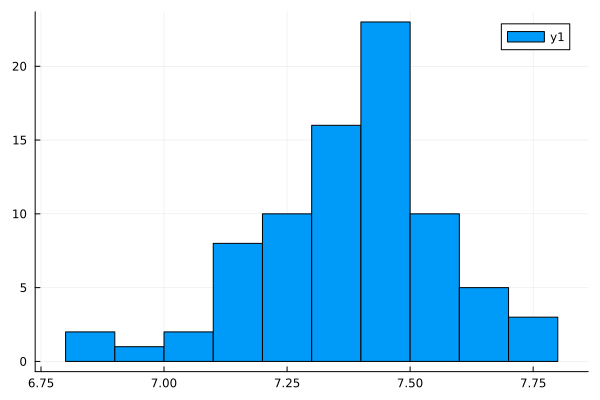

In [321]:
histogram(omics_pheno_processed[:, 832])

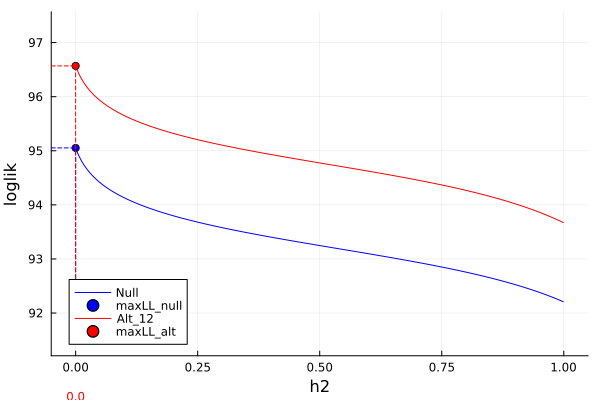

In [322]:
plotLL(reshape(omics_pheno_processed[:, 832], :, 1), omics_geno_processed, ones(n, 1), omics_kinship, fine_grid, 12; reml = false, x_lims = [0.0, 1.0], y_lims = [90.0, 100.0])

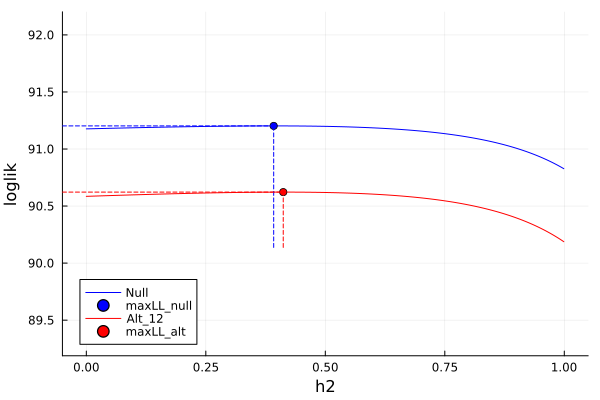

In [335]:
plotLL(reshape(omics_pheno_processed[:, 832], :, 1), omics_geno_processed, ones(n, 1), omics_kinship, fine_grid, 12; reml = true, x_lims = [0.0, 1.0], y_lims = [90.0, 100.0])

In [317]:
profileLL(reshape(omics_pheno_processed[:, 832], :, 1), omics_geno_processed, ones(n, 1), omics_kinship, [0.999999999999], 12; reml = true)

(ll_list_null = [90.82489858261012], ll_list_alt = [90.18466579096604])

## To run later...

In [83]:
grid_loose = [0.0, 0.99]

2-element Vector{Float64}:
 0.0
 0.99

In [257]:
# @time single_trait_na_bulklmm10 = scan(reshape(omics_pheno_processed[:, 832], :, 1), omics_geno_processed, omics_kinship; assumption = "alt", optim_interval = 4);

In [84]:
# t_alt_grid20 = @elapsed bulkscan_alt_grid_results = bulkscan_alt_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_loose);